# Language Agent Tree Search
Language Agent Tree Search (LATS) by Zhou et al. is a general LLM agent search algorithm that combines reflection/evaluation and search (specifically monte-carlo tree search) to achieve better overall task performance compared to similar techniques like ReACT, Reflexion or Tree of Thoughts

In [25]:
from dotenv import load_dotenv
load_dotenv()

import re
import os
import json
import math
import base64
import pprint
import asyncio
import datetime
import platform
import requests
import operator
import playwright
import numpy as np
import pandas as pd
import datetime as dt

from enum import Enum
from typing import List
from typing import Dict
from typing import Tuple
from typing import Union
from typing import Literal
from typing import Optional
from typing import Sequence
from typing import Annotated
from typing import TypedDict
from collections import deque
from operator import itemgetter
from collections import defaultdict

from IPython import display
from IPython.display import HTML
from IPython.display import Image

from langsmith import traceable

from langgraph.graph import END
from langgraph.graph import StateGraph
from langgraph.graph import MessageGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt.tool_executor import ToolInvocation

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from langchain_core.tools import StructuredTool
from langchain_core.messages import BaseMessage
from langchain_core.messages.ai import AIMessage
from langchain_core.messages.chat import ChatMessage
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.system import SystemMessage
from langchain_core.messages.function import FunctionMessage
from langchain_core.prompts.image import ImagePromptTemplate

from langchain_core.pydantic_v1 import Field
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import RunnableConfig
from langchain_core.runnables import RunnableParallel
from langchain_core.pydantic_v1 import ValidationError
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

from langchain_core.runnables.graph import CurveStyle
from langchain_core.runnables.graph import NodeColors
from langchain_core.runnables import chain as as_runnable
from langchain_core.runnables.graph import MermaidDrawMethod

from langchain import hub
from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import MessagesPlaceholder
from langchain.prompts import HumanMessagePromptTemplate
from langchain.prompts import SystemMessagePromptTemplate
from langchain.agents import create_openai_functions_agent
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.output_parsers.openai_tools import JsonOutputToolsParser

from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

from langchain_fireworks.chat_models import ChatFireworks

It has 4 main steps:
1. **Select**: pick the best next actions based on the aggregate rewards from step (2). Either respond (if a solution is found or the max search depth is reached) or continue searching.
2. **Expand and simulate**: select the "best" 5 potential actions and execute them in parallel.
3. **Reflect + Evaluate**: observe the outcomes of these actions and score the decisions based on reflection (and possibly external feedback)
4. **Backpropagate**: update the scores of the root trajectories based on the outcomes.

In [2]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'LATS'

LATS is based on (greedy) Monte Carlo tree search. For each search step, it picks the node with the highest "upper confidence bound", which is a metric that balances exploitation (highest average reward) and exploration (lowest visits). Starting from that node, it generates N (5 in this case) new candidate actions to take, and adds them to the tree. It stops searching either when it has generated a valid solution OR when it has reached the maximum number of rollouts (search tree depth)

Our LangGraph state will be composed of two items:
1. The root of the search tree
2. The user input

### Reflection
The reflection chain will score agent outputs based on the decision and the tool responses. We will call this within the other two nodes.

In [3]:
class Reflection(BaseModel):
    reflections: str = Field(description='The critique and reflections on the sufficiency, superfluency, and general quality of the response')
    score: int = Field(description='Score from 0 - 10 on the quality of the candidate response', gte=0, lte=10)
    found_solution: bool = Field(description='Whether the response has fully solved the question or task')
    
    def as_message(self):
        return HumanMessage(content=f'Reasoning: {self.reflections}\nScore: {self.score}')
    
    @property
    def normalized_score(self) -> float:
        return self.score / 10.0

In [7]:
class Node:
    def __init__(self, messages: List[BaseMessage], reflection: Reflection, parent=None):
        self.value = 0
        self.visits = 0
        self.children = []
        self.parent = parent
        self.messages = messages
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f'<Node value={self.value}, visits={self.visits},'
            f' solution={self.messages} reflection={self.reflection}/>'
        )
    
    @property
    def is_solved(self):
        '''If any solutions exist, we can end the search'''
        return self._is_solved
    
    @property
    def is_terminal(self):
        return not self.children
    
    @property
    def best_child(self):
        '''Select the child with the highest UCT to search next'''
        if not self.children:
            return None
        return max(self._get_all_children(), key=lambda child: child.upper_confidence_bound())
    
    @property
    def best_child_score(self):
        '''Return the child with the highest value'''
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)
    
    @property
    def height(self) -> int:
        '''Check for how far we've rolled out the tree'''
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1
    
    def upper_confidence_bound(self, exploration_weight=1.0):
        '''Return the UCT score. This helps balance exploration vs exploitation of a branch'''
        if self.parent is None:
            raise ValueError('Cannot obtain UCT from root node')
        if self.visits == 0:
            return self.value
        
        # encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits

        # encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term
    
    def backpropagate(self, reward: float):
        '''Update the score of this node and its parents'''
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool=True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages
    
    def get_trajectory(self, include_reflections: bool=True) -> List[BaseMessage]:
        '''Get messages representing this search branch'''
        messages = []
        node = self
        while node:
            messages.extend(node.get_messages(include_reflections=include_reflections)[::-1])
            node = node.parent

        # reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1] # root solution, reflection, child
    
    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        return all_nodes
    
    def get_best_solution(self):
        '''Return the best solution from within the current sub-tree'''
        all_nodes = [self] + self._get_all_children()
        best_node = max(all_nodes, key=lambda node: int(node.is_terminal and node.is_solved) * node.value)
        return best_node
    
    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent

In [8]:
class TreeState(TypedDict):
    root: Node # the full tree
    input: str # the original input

## Define Language Agent
Our agent will have three primary LLM-powered processes:
1. Reflect: score the action based on the tool response
2. Initial response: to create the root node and start the search
3. Expand: generate 5 candidate "next steps" from the best spot in the current tree

For more "grounded" tool applications (such as code synthesis), you could integrate code execution into the reflection / reward step. This type of external feedback is very useful (though adds complexity to an already complicated example notebook)

In [9]:
llm = ChatOpenAI(model='gpt-4o')

In [10]:
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_executor = ToolExecutor(tools=tools)

In [14]:
# reflection

prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'Reflect and grade the assistant response to the user question below.'
        ),
        (
            'user',
            '{input}'
        ),
        MessagesPlaceholder(variable_name='candidate')
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice='Reflection').with_config(run_name='Reflection')
    | PydanticToolsParser(tools=[Reflection])
)

@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = tool_choices[0]
    if not isinstance(inputs['candidate'][-1], AIMessage):
        reflection.found_solution = False
    return reflection

### Initial Response
We start with a single root node, generated by this first step. It responds to the user input either with a tool invocation or a response.

In [15]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are an AI assistant.'
        ),
        (
            'user',
            '{input}'
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

initial_answer_chain = (
    prompt_template
    | llm.bind_tools(tools=tools).with_config(run_name='GenerateInitialCandidate')
)

parser = JsonOutputToolsParser(return_id=True)

In [22]:
initial_response = initial_answer_chain.invoke({'input': 'Write a research report on lithium pollution.'})
initial_response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_iUfZAFT5pE43lTc9bXPAYRoK)
 Call ID: call_iUfZAFT5pE43lTc9bXPAYRoK
  Args:
    query: lithium pollution overview
  tavily_search_results_json (call_VaI5GEq2IzD8L0hKmYD6HawT)
 Call ID: call_VaI5GEq2IzD8L0hKmYD6HawT
  Args:
    query: environmental impact of lithium extraction
  tavily_search_results_json (call_odEkd2pR0Ghe7Y0dQV3kpPzr)
 Call ID: call_odEkd2pR0Ghe7Y0dQV3kpPzr
  Args:
    query: effects of lithium on human health
  tavily_search_results_json (call_Z7Oibhg6DAMdJPM2TfHh2lYv)
 Call ID: call_Z7Oibhg6DAMdJPM2TfHh2lYv
  Args:
    query: solutions to lithium pollution


### Starting Node
We will package up the candidate generation and reflection in a single node of our graph. This is represented by the following function.

In [23]:
def generate_initial_response(state: TreeState) -> dict:
    '''Generate the initial candidate response'''
    res = initial_answer_chain.invoke({'input': state['input']})
    parsed = parser.invoke(res)
    tool_responses = tool_executor.batch([ToolInvocation(tool=r['type'], tool_input=r['args']) for r in parsed])
    output_messages = [res] + [ToolMessage(content=json.dumps(resp), tool_call_id=tool_call['id']) for resp, tool_call in zip(tool_responses, parsed)]
    reflection = reflection_chain.invoke({'input': state['input'], 'candidate': output_messages})
    root = Node(output_messages, reflection=reflection)

    return {
        **state,
        'root': root
    }

### Candidate Generation
The following code prompts the same LLM to generate N additional candidates to check

In [26]:
# This generates N candidate values for a single input to sample actions from the environment

def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config['configurable'].get('N', 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config['callbacks'],
        run_name='GenerateCandidates',
        **bound_kwargs
    )
    return [gen.message for gen in chat_result.generations[0]]

expansion_chain = prompt_template | generate_candidates

In [30]:
res = expansion_chain.invoke({'input': 'Write a research report on lithium pollution.'})
for r in res:
    r.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1cxcBL5BUl5Z1lmOIe5TEBQR)
 Call ID: call_1cxcBL5BUl5Z1lmOIe5TEBQR
  Args:
    query: recent studies on lithium pollution 2023
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1cxcBL5BUl5Z1lmOIe5TEBQR)
 Call ID: call_1cxcBL5BUl5Z1lmOIe5TEBQR
  Args:
    query: lithium pollution research 2023
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1cxcBL5BUl5Z1lmOIe5TEBQR)
 Call ID: call_1cxcBL5BUl5Z1lmOIe5TEBQR
  Args:
    query: lithium pollution overview
  tavily_search_results_json (call_YL9uAzVTE0ZqKeshlonWZRwM)
 Call ID: call_YL9uAzVTE0ZqKeshlonWZRwM
  Args:
    query: environmental impact of lithium mining
  tavily_search_results_json (call_DFzaNtmwsZOPyd1WHJt5NV2A)
 Call ID: call_DFzaNtmwsZOPyd1WHJt5NV2A
 

### Candidate generation node
We will package the candidate generation and reflection steps in the following 'expand' node. We do all the operations as a batch process to speed up execution.

In [31]:
def expand(state: TreeState, config: RunnableConfig) -> dict:
    '''Starting from the "best" node in the tree, generate N candidates for the next step'''
    root = state['root']
    best_candidate: Node = root.best_child if root.children else root
    messages = best_candidate.get_trajectory()

    # generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke({'input': state['input'], 'messages': messages}, config)
    parsed = parser.batch(new_candidates)

    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]

    tool_responses = tool_executor.batch([
        ToolInvocation(tool=tool_call['type'], tool_input=tool_call['args'])
        for _, tool_call in flattened
    ])
    collected_responses = defaultdict(list)

    for (i, tool_call), resp in zip(flattened, tool_responses):
        collected_responses[i].append(ToolMessage(content=json.dumps(resp), tool_call_id=tool_call['id']))

    output_messages = []
    for i, candidate in  enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # reflect on each candidate
    # for tasks with external validation, you'd add that here
    reflections = reflection_chain.batch([{'input': state['input'], 'candidate': msges} for msges in output_messages], config)

    # grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]

    best_candidate.children.extend(child_nodes)

    # we have already extended the tree directly, so we just return the state
    return state

### Create Graph
With those two nodes defined, we are ready to define the graph. After each agent step, we have the option of finishing.

In [32]:
def should_loop(state: TreeState) -> Literal['expand', '__end__']:
    '''Determine whether to continue the tree search'''
    root = state['root']
    if root.is_solved:
        return END
    if root.height > 5:
        return END
    return 'expand'

builder = StateGraph(TreeState)
builder.add_node('start', generate_initial_response)
builder.add_node('expand', expand)
builder.set_entry_point('start')

builder.add_conditional_edges('start', should_loop)
builder.add_conditional_edges('expand', should_loop)

graph = builder.compile()

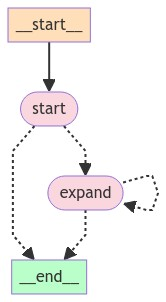

In [35]:
Image(graph.get_graph().draw_mermaid_png())

In [36]:
question = 'Generate a table with the average size and weight, as well as the oldest recorded instance of each of the top 5 most common birds.'
last_step = None
for step in graph.stream({'input': question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print('rolled out: ', step_state['root'].height)
    print('----')

start
rolled out:  1
----
expand
rolled out:  2
----


In [37]:
solution_node = last_step['expand']['root'].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

Based on the search results, I'll compile the relevant details to generate the table with the average size, weight, and oldest recorded instance of each of the top 5 most common birds. Here are the top 5 most common birds identified and their respective data:

1. **House Sparrow**:
   - **Average Size**: Approximately 16 cm in length.
   - **Average Weight**: Around 24-40 grams.
   - **Oldest Recorded Instance**: Approximately 13 years.

2. **American Robin**:
   - **Average Size**: About 25 cm in length.
   - **Average Weight**: Roughly 77 grams.
   - **Oldest Recorded Instance**: About 14 years.

3. **European Starling**:
   - **Average Size**: Approximately 20-23 cm in length.
   - **Average Weight**: Around 75-90 grams.
   - **Oldest Recorded Instance**: About 15 years.

4. **Mourning Dove**:
   - **Average Size**: About 31 cm in length.
   - **Average Weight**: Roughly 112-170 grams.
   - **Oldest Recorded Instance**: Approximately 31 years.

5. **Northern Cardinal**:
   - **Avera

In [39]:
question = 'Write out Magnus Carlsen series of moves in his game against Alireza Firouzja and propose an alternate strategy'
last_step = None
for step in graph.stream({'input': question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print('rolled out: ', step_state['root'].height)
    print('----')

start
rolled out:  1
----
expand
rolled out:  2
----
expand
rolled out:  3
----


In [40]:
solution_node = last_step['expand']['root'].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

I found a link that appears to have the complete game moves: [Carlsen vs Firouzja, 11th Norway Chess 2023](https://www.365chess.com/game.php?gid=4416560). I'll retrieve the series of moves from that game and then propose an alternate strategy.

Here is the series of moves in the game:

1. e4 c5
2. Nf3 d6
3. Bb5+ Nd7
4. d4 cxd4
5. Qxd4 a6
6. Bxd7+ Bxd7
7. O-O Nf6
8. Nc3 e6
9. Rd1 Be7
10. Bg5 Bc6
11. Qd3 O-O
12. Nd4 Rc8
13. a4 Qb6
14. a5 Qc5
15. Be3 Qh5
16. f3 Nd7
17. Nxc6 Rxc6
18. Ne2 Rfc8
19. c3 Ne5
20. Qb1 Nc4
21. Bf2 Qh6
22. Nd4 R6c7
23. Qc2 d5
24. exd5 exd5
25. Re1 Bf8
26. Re2 Qg6
27. Qxg6 hxg6
28. Nb3 Re7
29. Rc1 Rce8
30. Rxe7 Rxe7
31. Kf1 Re6
32. Rd1 Rd6
33. Re1 Rd8
34. Re2 f6
35. Ke1 Kf7
36. Kd1 Ne5
37. Kc2 Nc4
38. Kc1 Bd6
39. h3 Bc7
40. Kc2 Bxa5
41. Nb3 Bb6
42. Nd4 Rd7
43. Kb3 Ne5
44. Kc2 Nc4
45. Kd3 Re7
46. Rc2 Ne5+
47. Kd2 Nc4+
48. Kd3 Ne5+
49. Kd2 Rd7
50. Ke2 Bc7
51. Nb3 Bd6
52. Nd2 Re7
53. Kf1 Nd3
54. Nb3 Bf4
55. g3 Bh6
56. Nc5 Nxc5
57. Bxc5 Re6
58. h4 g5
59. hxg5 Bxg5
60. B

## Conclusion
LATS is reasonably fast and effective at solving complex reasoning tasks. A few notes that we've observed above:
1. While effective, the tree rollout can take additional compute time. If you wanted to include this in a production app, you'd either want to ensure that intermediate steps are streamed (so that the user sees the thinking process / has access to intermediate results) or use it for fine-tuning data to improve the single-shot accuracy and avoid long rollouts.
2. The candidate selection process is only as good as the reward you generate. Here we are using self-reflection exclusively, but if you have an external source of feedback (such as code test execution), that should be incorporated in the locations mentioned above.